<a href="https://colab.research.google.com/github/SiweiLuo/DL_with_Python/blob/master/vae_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import os 
import sys 


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
import matplotlib
import matplotlib.pyplot as plt 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


In [0]:
def plot_image(image,shape=[28,28]):
  plt.imshow(image.reshape(shape),cmap="Greys",interpolation="nearest")
  plt.axis("off")
 

In [0]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [0]:
import numpy.random as rnd 


rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])



In [8]:
import tensorflow as tf 

reset_graph()

n_inputs = 3 
n_hidden = 2 
n_outputs = n_inputs

learning_rate = 0.01 

x = tf.placeholder(tf.float32,shape=[None,n_inputs])
hidden = tf.layers.dense(x,n_hidden)
outputs = tf.layers.dense(hidden,n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-x))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
n_iterations = 1000
codings = hidden 

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    training_op.run(feed_dict={x:X_train})
  codings_val = codings.eval(feed_dict={x:X_test})
  
  

Saving figure linear_autoencoder_pca_plot


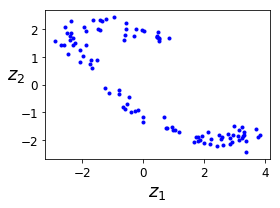

In [10]:
fig = plt.figure(figsize=(4,3))

plt.plot(codings_val[:,0],codings_val[:,1],"b.")
plt.xlabel("$z_1$",fontsize=18)
plt.ylabel("$z_2$",fontsize=18,rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()



In [11]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
reset_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs 


learning_rate = 0.01 
l2_reg = 0.0001

x = tf.placeholder(tf.float32,shape=[None,n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(x,n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2)
hidden3 = my_dense_layer(hidden2,n_hidden3)
outputs = my_dense_layer(hidden3,n_outputs,activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-x))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss]+reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()



In [13]:
n_epochs = 5 
batch_size = 150 

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size 
    for iteration in range(n_batches):
      print("\r{}%".format(100*iteration // n_batches),end="")
      
      sys.stdout.flush()
      X_batch,y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op,feed_dict={x:X_batch})
    loss_train = reconstruction_loss.eval(feed_dict={x:X_batch})
    print("\r{}".format(epoch),"Train MSE:",loss_train)
    saver.save(sess,"./my_model_all_layers.ckpt")


0 Train MSE: 0.021799065
1 Train MSE: 0.011398722
2 Train MSE: 0.010222834
3 Train MSE: 0.009901937
4 Train MSE: 0.010377128


In [0]:
def show_reconstructed_digits(x,outputs,model_path = None,n_test_digits=2):
  with tf.Session() as sess:
    if model_path:
      saver.restore(sess,model_path)
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={x:X_test})
    
  fig = plt.figure(figsize=(8,3*n_test_digits))
  
  for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits,2,digit_index*2+1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits,2,digit_index*2+2)
    plot_image(outputs_val[digit_index])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure reconstruction_plot


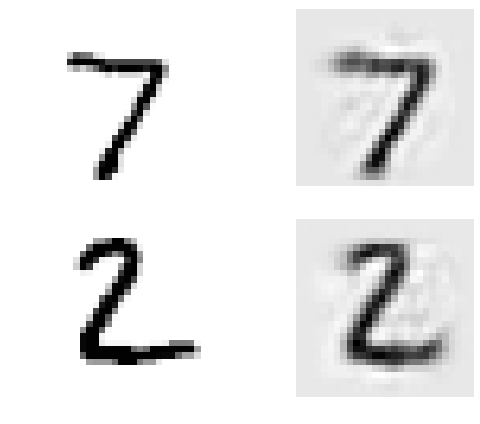

In [16]:
show_reconstructed_digits(x,outputs,"./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

In [0]:
reset_graph()

n_inputs = 28*28 
n_hidden1 = 300
n_hidden2 = 150 
n_hidden3 = n_hidden1 
n_outputs = n_inputs 

learning_rate = 0.01 
l2_reg = 0.0005 


In [0]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

x = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])

weights1 = tf.Variable(weights1_init,dtype=tf.float32,name="weights1")
weights2 = tf.Variable(weights2_init,dtype=tf.float32,name="weights2")
weights3 = tf.transpose(weights2,name="weights3")
weights4 = tf.transpose(weights1,name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1),name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3),name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs),name="biases4")

hidden1 = activation(tf.matmul(x,weights1)+biases1)
hidden2 = activation(tf.matmul(hidden1,weights2)+biases2)
hidden3 = activation(tf.matmul(hidden2,weights3)+biases3)
outputs = tf.matmul(hidden3,weights4)+biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs-x))
reg_loss = regularizer(weights1)+regularizer(weights2)
loss = reconstruction_loss+reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [0]:
saver = tf.train.Saver()

In [20]:
n_epochs = 5 
batch_size = 150 

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size 
    for iteration in range(n_batches):
      print("\r{}%".format(100*iteration//n_batches),end="")
      sys.stdout.flush()
      X_batch,y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op,feed_dict={x:X_batch})
      
    loss_train = reconstruction_loss.eval(feed_dict={x:X_batch})
    print("\r{}".format(epoch),"Train MSE:",loss_train)
    saver.save(sess,"./my_model_all_layers.ckpt")
  





0 Train MSE: 0.015066946
1 Train MSE: 0.016488738
2 Train MSE: 0.017375926
3 Train MSE: 0.016878327
4 Train MSE: 0.015587719


INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


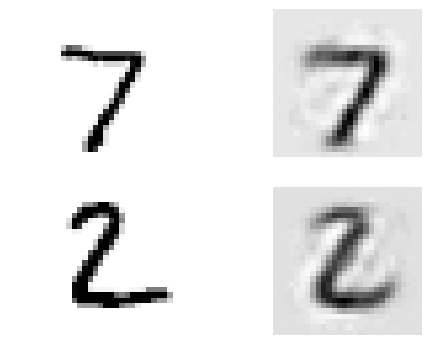

In [21]:
show_reconstructed_digits(x,outputs,"./my_model_all_layers.ckpt")

In [0]:
reset_graph()

from functools import partial

def train_autoencoder(X_train,n_neurons,n_epochs,batch_size,
                     learning_rate = 0.01,l2_reg = 0.0005,seed=42,
                     hidden_activation=tf.nn.elu,
                     output_activation=tf.nn.elu):
  graph = tf.Graph()
  with graph.as_default():
    tf.set_random_seed(seed)
    n_inputs = X_train.shape[1]
    
    x = tf.placeholder(tf.float32,shape=[None,n_inputs])
    my_dense_layer = partial(
    tf.layers.dense,
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(),
    kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg))
    
    hidden = my_dense_layer(x, n_neurons, activation=hidden_activation, name="hidden")
    outputs = my_dense_layer(hidden,n_inputs,activation=output_activation,name="outputs")
    
    reconstruction_loss = tf.reduce_mean(tf.square(outputs-x))
    
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss]+reg_losses)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
    
    init = tf.global_variables_initializer()
    
  with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
      n_batches = len(X_train) // batch_size
      for iteration in range(n_batches):
        print("\r{}%".format(100*iteration // n_batches),end="")
        sys.stdout.flush()
        indices = rnd.permutation(len(X_train))[:batch_size]
        X_batch = X_train[indices]
        sess.run(train_op,feed_dict={x:X_batch})
      loss_train = reconstruction_loss.eval(feed_dict={x:X_batch})
      print("\r{}".format(epoch),"Train MSE:",loss_train)
    params = dict([(var.name,var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
    hidden_val = hidden.eval(feed_dict={x:X_train})
    
    return hidden_val,params["hidden/kernel:0"],params["hidden/bias:0"],params["outputs/kernel:0"],params["outputs/bias:0"]






In [0]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
        

In [24]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.018517934
1 Train MSE: 0.018682716
2 Train MSE: 0.018467715
3 Train MSE: 0.019231727
0 Train MSE: 0.004236107
1 Train MSE: 0.004832679
2 Train MSE: 0.0046687447
3 Train MSE: 0.004403908


In [0]:
reset_graph()

n_inputs = 28*28 

x = tf.placeholder(tf.float32,shape=[None,n_inputs])

hidden1 = tf.nn.elu(tf.matmul(x,W1)+b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1,W2)+b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2,W3)+b3)
outputs = tf.matmul(hidden3,W4)+b4




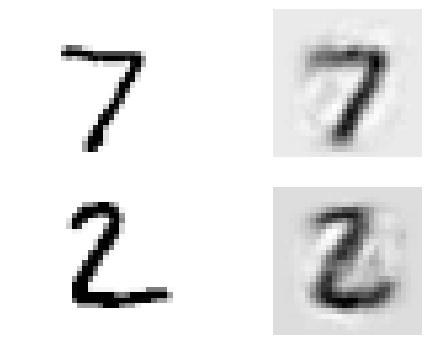

In [26]:
show_reconstructed_digits(x,outputs)

In [0]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150 
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01 
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

x = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])
weights3_init = initializer([n_hidden2,n_hidden3])
weights4_init = initializer([n_hidden3,n_outputs])


weights1 = tf.Variable(weights1_init,dtype=tf.float32,name="weights1")
weights2 = tf.Variable(weights2_init,dtype=tf.float32,name="weights2")
weights3 = tf.Variable(weights3_init,dtype=tf.float32,name="weights3")
weights4 = tf.Variable(weights4_init,dtype=tf.float32,name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1),name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3),name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs),name="biases4")

hidden1 = activation(tf.matmul(x,weights1)+biases1)
hidden2 = activation(tf.matmul(hidden1,weights2)+biases2)
hidden3 = activation(tf.matmul(hidden2,weights3)+biases3)
outputs = tf.matmul(hidden3,weights4)+biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs-x))







In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
  phase1_outputs = tf.matmul(hidden1,weights4)+biases4
  phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs-x))
  phase1_reg_loss = regularizer(weights1)+regularizer(weights4)
  phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
  phase1_training_op = optimizer.minimize(phase1_loss)
  
with tf.name_scope("phase2"):
  phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3-hidden1))
  phase2_reg_loss = regularizer(weights2)+regularizer(weights3)
  phase2_loss = phase2_reconstruction_loss+phase2_reg_loss
  train_vars = [weights2,biases2,weights3,biases3]
  phase2_training_op = optimizer.minimize(phase2_loss,var_list=train_vars)
  
  

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
training_ops = [phase1_training_op,phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss,phase2_reconstruction_loss]
n_epochs = [4,4]
batch_sizes = [150,150]

with tf.Session() as sess:
  init.run()
  for phase in range(2):
    print("Training phase #{}".format(phase+1))
    for epoch in range(n_epochs[phase]):
      n_batches = mnist.train.num_examples // batch_sizes[phase]
      for iteration in range(n_batches):
        print("\r{}%".format(100*iteration//n_batches),end="")
        sys.stdout.flush()
        X_batch,y_batch = mnist.train.next_batch(batch_sizes[phase])
        sess.run(training_ops[phase],feed_dict={x:X_batch})
        
      loss_train = reconstruction_losses[phase].eval(feed_dict={x:X_batch})
      print("\r{}".format(epoch),"Train MSE:",loss_train)
      saver.save(sess,"./my_model_all_layers.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={x:X_batch})
    print("Test MSE:",loss_test)
    
    
    
        



Training phase #1
0 Train MSE: 0.0074068652
1 Train MSE: 0.007828818
2 Train MSE: 0.0077280947
3 Train MSE: 0.0074090054
Test MSE: 0.108815186
Training phase #2
0 Train MSE: 0.30220637
1 Train MSE: 0.0060562417
2 Train MSE: 0.002984181
3 Train MSE: 0.0024322334
Test MSE: 0.01041548


In [39]:
training_ops = [phase1_training_op,phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss,phase2_reconstruction_loss]
n_epochs = [4,4]
batch_sizes = [150,150]


with tf.Session() as sess:
  init.run()
  for phase in range(2):
    print("Training phase #{}".format(phase+1))
    if phase == 1:
      hidden1_cache = hidden1.eval(feed_dict={x:mnist.train.images})
      
    for epoch in range(n_epochs[phase]):
      n_batches = mnist.train.num_examples // batch_sizes[phase]
      for iteration in range(n_batches):
        print("\r{}%".format(100*iteration // n_batches),end="")
        sys.stdout.flush()
        if phase == 1:
          indices = rnd.permutation(mnist.train.num_examples)
          hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
          feed_dict = {hidden1:hidden1_batch}
          sess.run(training_ops[phase],feed_dict=feed_dict)
          
        else: 
          X_batch,y_batch = mnist.train.next_batch(batch_sizes[phase])
          feed_dict = {x:X_batch}
          sess.run(training_ops[phase],feed_dict=feed_dict)
      loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
      print("\r{}".format(epoch),"Train MSE:",loss_train)
      saver.save(sess,"../my_model_all_layers.ckpt")
  loss_test = reconstruction_loss.eval(feed_dict={x:mnist.test.images})
  print("Test MSE:",loss_test)
  








Training phase #1
0 Train MSE: 0.007959753
1 Train MSE: 0.0073073367
2 Train MSE: 0.007790841
3 Train MSE: 0.008242568
Training phase #2
0 Train MSE: 0.13902962
1 Train MSE: 0.005474853
2 Train MSE: 0.00256196
3 Train MSE: 0.0021418293
Test MSE: 0.00981761


INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


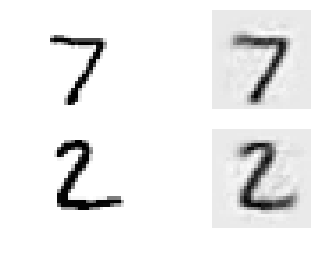

In [41]:
n_test_digits = 2 
X_test = mnist.test.images[:n_test_digits]


with tf.Session() as sess:
  saver.restore(sess,"./my_model_all_layers.ckpt")
  outputs_val = outputs.eval(feed_dict={x:X_test})
  
def plot_image(image,shape=[28,28]):
  plt.imshow(image.reshape(shape),cmap="Greys",interpolation="nearest")
  plt.axis("off")
  
  
for digit_index in range(n_test_digits):
  plt.subplot(n_test_digits,2,digit_index*2+1)
  plot_image(X_test[digit_index])
  plt.subplot(n_test_digits,2,digit_index*2+2)
  plot_image(outputs_val[digit_index])





INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure extracted_features_plot


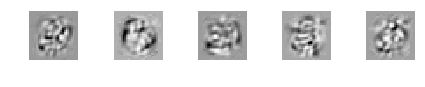

In [42]:

with tf.Session() as sess:
  saver.restore(sess,"./my_model_all_layers.ckpt")
  weights1_val = weights1.eval()
  
for i in range(5):
  plt.subplot(1,5,i+1)
  plot_image(weights1_val.T[i])
  
save_fig("extracted_features_plot")
plt.show()






In [0]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150 
n_outputs = 10 

learning_rate = 0.01 
l2_reg = 0.00005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

x = tf.placeholder(tf.float32,shape=[None,n_inputs])
y = tf.placeholder(tf.int32,shape=[None])


weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])
weights3_init = initializer([n_hidden2,n_outputs])

weights1 = tf.Variable(weights1_init,dtype=tf.float32,name="weights1")
weights2 = tf.Variable(weights2_init,dtype=tf.float32,name="weights2")
weights3 = tf.Variable(weights3_init,dtype=tf.float32,name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1),name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs),name="biases3")

hidden1 = activation(tf.matmul(x,weights1)+biases1)
hidden2 = activation(tf.matmul(hidden1,weights2)+biases2)
logits = tf.matmul(hidden2,weights3)+biases3


cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1,weights2,biases1,biases2])
saver = tf.train.Saver()







In [49]:
n_epochs = 4 
batch_size = 150 
n_labeled_instances = 20000

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = n_labeled_instances
    for iteration in range(n_batches):
      print("\r{}%".format(100*iteration // n_batches),end="")
      sys.stdout.flush()
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      X_batch,y_batch = mnist.train.images[indices],mnist.train.labels[indices]
      sess.run(training_op,feed_dict={x:X_batch,y:y_batch})
    accuracy_val = accuracy.eval(feed_dict={x:X_batch,y:y_batch})
    print("\r{}".format(epoch),"Train accuracy:",accuracy_val,end="")
    saver.save(sess,"./my_model_all_layers.ckpt")
    accuracy_val = accuracy.eval(feed_dict={x:mnist.test.images,y:mnist.test.labels})
    print("Test accuracy:",accuracy_val)
    






0 Train accuracy: 0.99333334Test accuracy: 0.9538
1 Train accuracy: 1.0Test accuracy: 0.9588
2 Train accuracy: 0.9866667Test accuracy: 0.9607
3 Train accuracy: 0.99333334Test accuracy: 0.9543


In [51]:
n_epochs = 4 
batch_size = 150 
n_labeled_instances = 20000

with tf.Session() as sess: 
  init.run()
  pretrain_saver.restore(sess,"./my_model_all_layers.ckpt")
  for epoch in range(n_epochs):
    n_batches = n_labeled_instances // batch_size 
    for iteration in range(n_batches):
      print("\r{}%".format(100*iteration//n_batches),end="")
      sys.stdout.flush()
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      X_batch,y_batch = mnist.train.images[indices],mnist.train.labels[indices]
      sess.run(training_op,feed_dict={x:X_batch,y:y_batch})
    accuracy_val = accuracy.eval(feed_dict={x:X_batch,y:y_batch})
    print("\r{}".format(epoch),"Train accuracy:",accuracy_val,end="")
    saver.save(sess,"./my_model_all_layers.ckpt")
    accuracy_val = accuracy.eval(feed_dict={x:mnist.test.images,y:mnist.test.labels})
    print("Test accuracy:",accuracy_val)






INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
0 Train accuracy: 1.0Test accuracy: 0.9571
1 Train accuracy: 1.0Test accuracy: 0.963
2 Train accuracy: 0.9866667Test accuracy: 0.9527
3 Train accuracy: 1.0Test accuracy: 0.9618
